# The preceeding ipynb is semi more general in selecting it's blurring region.
# It is capable of selecting cuboid, i.e. unequal sides
# This ipynb restricts to only cubes, i.e. equal sides, as an attempt to be more computationally efficient
# The reason for this restriction relies on the assumption that the blurring region are spheres

## Importing Libraries

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
# import logging
import numpy as np
import py21cmfast as p21c
# import caffeine
import time as time
import logging, sys, os

## Daily Python Zen

In [ ]:
import this

## Set logger to log caching activity

In [ ]:
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

## Version of 21cmFAST

In [4]:
print(f"Using 21cmFAST version {p21c.__version__}")

Using 21cmFAST version 3.0.0.dev5


## Number of cores running

In [ ]:
print(f'Number of threads running = {os.cpu_count()}')

## Reset cache location 

In [6]:
p21c.config['direc'] = '/lustre/aoc/projects/hera/wchin/21cmFAST-cache'

## Gaussian function

In [7]:
def Gaussian(x, sigma):  # μ=0, σ=1/sqrt(2), π=1
    Gaussian = np.exp(-(x/sigma)**2)
    return Gaussian

## Measure the distance of each voxel to the center

In [8]:
def distance_from_coordinate(box_length):
        
    index = np.arange(-0.5*(box_length-1), 0.5*(box_length+1))

    x_mesh, y_mesh, z_mesh = np.meshgrid(index, index, index, indexing='ij')
    
    distance = np.sqrt((x_mesh)**2 + (y_mesh)**2 + (z_mesh)**2)
    
    return distance

## Random Coordinate

In [9]:
def random_voxel(box_length):
    
    np.random.seed()  # set seed to a randome number
#     np.random.seed(4) ; np.random.rand(10)  # specifying seed for testing purposes

    coordinate = np.random.randint(0, box_length, size=3)

    return coordinate

## Select a Smaller Cube with Sides 2R+1 Voxels, Centered about the Random Coordinate

In [10]:
def cube_centered_about_coordinate(coordinate_array, radius, box):
    x_ind1 = int(coordinate_array[0]-radius)  # x-domian
    x_ind2 = int(coordinate_array[0]+radius+1)  # ending index is not inclusive
    y_ind1 = int(coordinate_array[1]-radius)  # y-domain
    y_ind2 = int(coordinate_array[1]+radius+1)
    z_ind1 = int(coordinate_array[2]-radius)  # z-domain
    z_ind2 = int(coordinate_array[2]+radius+1)
        
    if x_ind1 < 0:  # periodic boundary conditions
        x_inds = np.r_[(x_ind1+len(box)):len(box), 0:x_ind2]
    elif x_ind2 > len(box):
        x_inds = np.r_[x_ind1:len(box), 0:(x_ind2-len(box))]
    else:
        x_inds = np.r_[x_ind1:x_ind2]

    if y_ind1 < 0:
        y_inds = np.r_[(y_ind1+len(box)):len(box), 0:y_ind2]
    elif y_ind2 > len(box):
        y_inds = np.r_[y_ind1:len(box), 0:(y_ind2-len(box))]
    else:
        y_inds = np.r_[y_ind1:y_ind2]

    if z_ind1 < 0:
        z_inds = np.r_[(z_ind1+len(box)):len(box), 0:z_ind2]
    elif z_ind2 > len(box):
        z_inds = np.r_[z_ind1:len(box), 0:(z_ind2-len(box))]
    else:
        z_inds = np.r_[z_ind1:z_ind2]
            
    indices = np.ix_(x_inds, y_inds, z_inds)
        
    try:
        output_box = box[indices]
    except IndexError:
        print(f'coordinate array = {coordinate_array}')
        print(f'radius = {radius}')
        print(f'box length = {len(box)}')
        print(f'x_ind1 = {x_ind1}')
        print(f'x_ind2 = {x_ind2}')
        print(f'x_inds = {x_inds}')
        print(f'x_ind1 = {y_ind1}')
        print(f'x_ind2 = {y_ind2}')
        print(f'y_inds = {y_inds}')
        print(f'x_ind1 = {z_ind1}')
        print(f'x_ind2 = {z_ind2}')
        print(f'z_inds = {z_inds}')
        
    return output_box

## Gausssian Sphere Averaging

In [11]:
def gaussian_sphere_average(distance_box, radius, input_box, shell_num, sigma_factor):
    
    mean = []

    shell_radius_edges = np.linspace(0,1,shell_num+1)
    # sigma_factor number of sigmas the weighting goes out to, sigma = radius
    
    
    # Radius Ratio 1
#     shell_center = 0.5*(shell_radius_edges[1:] + shell_radius_edges[:-1])*sigma_factor 
#     weight = Gaussian(x=shell_center, sigma=1)
    
    # Radius Ratio 2
    shell_center = 0.5*(shell_radius_edges[1:] + shell_radius_edges[:-1])*sigma_factor*radius
    weight = Gaussian(x=shell_center, sigma=radius)

    
    for ii in range(shell_num):
        condition = np.logical_and(
            distance_box <= shell_radius_edges[ii+1]*radius, 
            distance_box > shell_radius_edges[ii]*radius
        )
        inside_shell_mean = np.mean(input_box[condition])
        mean = np.append(mean, inside_shell_mean)
        
    Gaussian_mean = np.average(mean, weights=weight)
    
    return Gaussian_mean

## Top Hat Sphere Averaging

In [12]:
def top_hat_sphere_average(distance_box, radius, input_box):
    
    condition = distance_box <= radius
    mean = np.mean(input_box[condition])
    
    return mean

## Top Hat Cube Averaging

In [13]:
def top_hat_cube_average(input_box):
    
    mean = np.mean(input_box)
    
    return mean

## Sphere Blurring Function

In [14]:
def Average_Neutral_Fraction_Distribution(
    box, 
    radius, 
    iteration, 
    shell_num=6, 
    sigma_factor=4, 
    blur_shape=None
):
    
    box = box.copy()  # make copy of input box to have a separate box
    
    mean_data = []  # empty list for data collection
    
    if blur_shape == 'Gaussian_sphere':
        
        
# ======================================================================================================================
        # Radius Ratio 1
#         radius = int(round(radius*1.4370396997748922*3))
        
        # Radius Ratio 2
        radius = int(round(radius*((4/3/np.sqrt(np.pi))**(1/3))*13/4))  # 13/4 --> speculated correction factor
# ======================================================================================================================
        
        
        # check to see if averaging region is largert than the box itself
        if radius > (len(box)-1)/2:
            print(f'Radius = {radius} > {(len(box)-1)/2} = (Box Length-1)/2, averaging region is larger than the box itself.')
            print('Code terminated.')
            sys.exit()
            
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = gaussian_sphere_average(dist_frm_coord_box, radius, cube_region_box, shell_num, sigma_factor)
            mean_data = np.append(mean_data, mean)
        
    elif blur_shape == 'top_hat_sphere':
        
        # check to see if averaging region is largert than the box itself
        if radius > (len(box)-1)/2:
            print(f'Radius = {radius} > {(len(box)-1)/2} = (Box Length-1)/2, averaging region is larger than the box itself.')
            print('Code terminated.')
            sys.exit()

        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = top_hat_sphere_average(dist_frm_coord_box, radius, cube_region_box)
            mean_data = np.append(mean_data, mean)
            
    elif blur_shape == 'top_hat_cube':
                
        radius = int(round((radius*((4*np.pi/3)**(1/3))-1)/2))  # ratio determiend by equating the volumes of cube & sphere

        # check to see if averaging region is largert than the box itself
        if radius > (len(box)-1)/2:
            print(f'Radius = {radius} > {(len(box)-1)/2} = (Box Length-1)/2, averaging region is larger than the box itself.')
            print('Code terminated.')
            sys.exit()
        
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = top_hat_cube_average(cube_region_box)
            mean_data = np.append(mean_data, mean)
    else:
        print('Blurring shape assumed to be a Gaussian sphere with 4 shells \
              weighted by equally spaced values from 0 sigma to 4 sigma.')
                
        
# ======================================================================================================================
        # Radius Ratio 1
#         radius = int(round(radius*1.4370396997748922*3))
        
        # Radius Ratio 2
        radius = int(round(radius*((4/3/np.sqrt(np.pi))**(1/3))*13/4))  # 13/4 --> speculated correction factor
# ======================================================================================================================
        
        
        # check to see if averaging region is largert than the box itself
        if radius > (len(box)-1)/2:
            print(f'Radius = {radius} > {(len(box)-1)/2} = (Box Length-1)/2, averaging region is larger than the box itself.')
            print('Code terminated.')
            sys.exit()
        
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = gaussian_sphere_average(dist_frm_coord_box, radius, cube_region_box, shell_num, sigma_factor)
            mean_data = np.append(mean_data, mean)
            
    return mean_data

## Histogram Function

In [15]:
def histogram(
    y1s, 
    figure_shape, 
    y2s=None,
    y3s=None,
    marker_lines=None,
    y1s_label=None,
    y2s_label=None,
    y3s_label=None,
    title=None, 
    shared_title=None,
    shared_title_x_position=0.5,   # figure coordinates, max=1 I think
    shared_title_y_position=0.92,
    shared_x_label=None, 
    shared_x_label_x_position=0.5,
    shared_x_label_y_position=0.08,
    shared_y_label=None, 
    shared_y_label_x_position=0.07,
    shared_y_label_y_postion=0.5,
    x_start=0, 
    x_stop=1, 
    bin_num=100, 
    color='white', 
    figure_size=(18,7), 
    font_size=15, 
    horizontal_gap=0.05, 
    vertical_gap=0.05, 
    y_scale='linear', 
    y_notation='plain', 
    share_x_axis=True, 
    share_y_axis=True,
    dpi=100
):  # a: x start, b: x stop
    
    bin_edges = np.linspace(x_start, x_stop, bin_num) # 100 bins from 0-1
    
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    if type(y1s) == tuple:  # hopefully more robust condition.
        
        fig, axes = plt.subplots(
            figure_shape[0], 
            figure_shape[1], 
            figsize=figure_size, 
            sharex=share_x_axis, 
            sharey=share_y_axis, 
            gridspec_kw={"hspace":vertical_gap, 'wspace':horizontal_gap},
            dpi=dpi
        )
        
        if shared_title != None:
            
            fig.suptitle(
                x=shared_title_x_position, 
                y=shared_title_y_position, 
                t=shared_title, ha='center', 
                size=1.5*font_size, 
                color=color
            )
            
        if shared_x_label != None:  # shared x label
            fig.text(
                x=shared_x_label_x_position, 
                y=shared_x_label_y_position, 
                s=shared_x_label, ha='center', 
                size=font_size, 
                color=color
            )

        if shared_y_label != None:  # shared y label
            fig.text(
                x=shared_y_label_x_position, 
                y=shared_y_label_y_postion, 
                s=shared_y_label, 
                va='center', 
                rotation='vertical', 
                size=font_size, 
                color=color
            )
        
        for i, y1 in enumerate(y1s):
            axes.flatten()[i].plot(
                bin_centers, 
                np.histogram(y1, bins=bin_edges)[0], 
                label=y1s_label
            )
            
            if y2s != None:
                axes.flatten()[i].plot(
                    bin_centers, 
                    np.histogram(y2s[i], bins=bin_edges)[0], 
                    '--', 
                    label=y2s_label
                )
                
                if iterable(y3s):
                    
                    
#                     #-------------temporary-------------#
                    
#                     shell_numbers = [int(radii[i]/3), int(radii[i]*2/3)]
                    
#                     #-------------temporary-------------#

                    
                    for ii, marker_line in enumerate(marker_lines):
                        axes.flatten()[i].plot(
                            bin_centers, 
                            np.histogram(y3s[i,ii,:], bins=bin_edges)[0], 
                            marker_line, 
                            label=f'{y3s_label} {sigma_factors[ii]}σ {shell_numbers[ii]}shell'
                        )
                    axes.flatten()[i].legend()
                    
                else:
                    axes.flatten()[i].legend()
                
            if title != None:
                axes.flatten()[i].set_title(title[i], color=color, fontsize=font_size)
                
            axes.flatten()[i].set_yscale(y_scale)
            
            if y_notation == 'sci':
                axes.flatten()[i].ticklabel_format(
                    axis='y', 
                    style=y_notation, 
                    scilimits=(0,0), 
                    useMathText=True
                )
                
            axes.flatten()[i].tick_params(
                color=color, 
                labelcolor=color, 
                labelsize=font_size, 
                size=font_size
            )  # font style

            for spine in axes.flatten()[i].spines.values():  # figure color
                spine.set_edgecolor(color)
                
    else:
        
        fig, ax = plt.subplots(figsize=figure_size)
        
        ax.plot(bin_centers, np.histogram(y1s, bins=bin_edges)[0], label=y1s_label)
        
        if y2s != None:
            ax.plot(bin_centers, np.histogram(y2s, bins=bin_edges)[0], '--', label=y2s_label)
            
            if y3s == None:
                ax.legend()
                
            else:
                ax.plot(bin_centers, np.histogram(y3s, bins=bin_edges)[0], '-.', label=y3s_label)
                ax.legend()
                
        if title != None:
            ax.set_title(title, color=color, fontsize=font_size)
            
        ax.set_yscale(y_scale)
        
        if y_notation == 'sci':
            ax.ticklabel_format(axis='y', style=y_notation, scilimits=(0,0), useMathText=True)
            
        ax.tick_params(color=color, labelcolor=color, labelsize=font_size)  # font style

        for spine in ax.spines.values():  # figure color
            spine.set_edgecolor(color)
            
    plt.show()

## Plots

In [16]:
def plots(
    x_vals, 
    y1s, 
    figure_shape, 
    y2s=None, 
    y3s=None, 
    y4s=None,
    y5s=None,
    y6s=None,
    y7s=None,
    y1s_label=None, 
    y2s_label=None, 
    y3s_label=None,
    y4s_label=None,
    y5s_label=None,
    y6s_label=None,
    y7s_label=None,
    title=None,
    shared_title=None,
    shared_title_x_position=0.5,   # figure coordinates, max=1 I think
    shared_title_y_position=0.92,
    shared_x_label=None, 
    shared_x_label_x_position=0.5,
    shared_x_label_y_position=0.08,
    shared_y_label=None, 
    shared_y_label_x_position=0.07,
    shared_y_label_y_postion=0.5,
    y_label=None, 
    color='white', 
    figure_size=(18,7), 
    font_size=15, 
    horizontal_gap=0.05, 
    vertical_gap=0.05, 
    y_scale='linear', 
    y_notation='plain', 
    share_x_axis=True, 
    share_y_axis=True,
    dpi=100
):  # a: x start, b: x stop
    
    if type(y1s) == tuple:  # hopefully more robust condition.
        
        fig, axes = plt.subplots(
            figure_shape[0], 
            figure_shape[1], 
            figsize=figure_size, 
            sharex=share_x_axis, 
            sharey=share_y_axis, 
            gridspec_kw={"hspace":vertical_gap, 'wspace':horizontal_gap},
            dpi=dpi
        )
        
        for i, y1 in enumerate(y1s):
            
            axes.flatten()[i].plot(x_vals, y1, label=y1s_label)  # plotting f
            
            if y2s != None:  # plotting g if iterable is inputted
                axes.flatten()[i].plot(
                    x_vals, 
                    y2s[i], 
                    '--', 
                    label=y2s_label
                )
                
                if y3s == None:
                    axes.flatten()[i].legend()
                    
                else:  # plotting h if iterable is inputted
                    axes.flatten()[i].plot(
                        x_vals, 
                        y3s[i], 
                        '-.', 
                        label=y3s_label
                    )
                    
                    if y4s == None:
                        axes.flatten()[i].legend()
                        
                    else:
                        axes.flatten()[i].plot(
                            x_vals, 
                            y4s[i], 
                            ':', 
                            label=y4s_label
                        )
                        
                        if y5s == None:
                            axes.flatten()[i].legend()
                            
                        else:
                            axes.flatten()[i].plot(
                                x_vals, 
                                y5s[i], 
                                '-o', 
                                label=y5s_label
                            )
                            
                            if y6s == None:
                                axes.flatten()[i].legend()
                            
                            else:
                                axes.flatten()[i].plot(
                                    x_vals, 
                                    y6s[i], 
                                    '--', 
                                    label=y6s_label, 
                                    linewidth=4
                                )
                                
                                if y7s == None:
                                    axes.flatten()[i].legend()
                            
                                else:
                                    axes.flatten()[i].plot(
                                        x_vals, 
                                        y7s[i], 
                                        '-.', 
                                        label=y7s_label, 
                                        linewidth=4
                                    )
                                    axes.flatten()[i].legend()
            
            if title != None:  # title if inputted
                axes.flatten()[i].set_title(title[i], color=color, fontsize=font_size)
            
            if y_label != None:  # y label if inputted
                axes.flatten()[i].set_ylabel(y_label[i], color=color, fontsize=font_size)
                
            if shared_title != None:
                fig.suptitle(
                    x=shared_title_x_position, 
                    y=shared_title_y_position, 
                    t=shared_title, ha='center', 
                    size=1.5*font_size, 
                    color=color
                )
                
            if shared_x_label != None:  # shared x label
                fig.text(
                    x=shared_x_label_x_position, 
                    y=shared_x_label_y_position, 
                    s=shared_x_label, ha='center', 
                    size=font_size, 
                    color=color
                )
            
            if shared_y_label != None:  # shared y label
                fig.text(
                    x=shared_y_label_x_position, 
                    y=shared_y_label_y_postion, 
                    s=shared_y_label, 
                    va='center', 
                    rotation='vertical', 
                    size=font_size, 
                    color=color
                )
            
            axes.flatten()[i].set_yscale(y_scale)  # y axis linear or log scale
            
            if y_notation == 'sci':  # plain or scientific notation
                axes.flatten()[i].ticklabel_format(
                    axis='y', 
                    style=y_notation, 
                    scilimits=(0,0), 
                    useMathText=True
                )
            
            axes.flatten()[i].tick_params(
                color=color, 
                labelcolor=color, 
                labelsize=font_size, 
                size=font_size
            )  # font style
            
            for spine in axes.flatten()[i].spines.values():  # figure spine color
                spine.set_edgecolor(color)

    else:
        
        fig, ax = plt.subplots(figsize=figure_size)  # creating subplots
        
        ax.plot(x_vals, y1s, label=y1s_label)  # plotting f
        
        if y2s != None:  # plotting g if inputted
            ax.plot(
                x_vals, 
                y2s, 
                '--', 
                label=y2s_label
            )
            
            if y3s == None:
                ax.legend()

            else:  # plotting h if iterable is inputted
                ax.plot(
                    x_vals, 
                    y3s, 
                    '-.', 
                    label=y3s_label
                )

                if y4s == None:
                    ax.legend()

                else:
                    ax.plot(
                        x_vals, 
                        y4s, 
                        ':', 
                        label=y4s_label
                    )

                    if y5s == None:
                        ax.legend()

                    else:
                        ax.plot(
                            x_vals, 
                            y5s, 
                            '-o', 
                            label=y5s_label
                        )

                        if y6s == None:
                            ax.legend()

                        else:
                            ax.plot(
                                x_vals, 
                                y6s, 
                                '-*', 
                                label=y6s_label
                            )

                            if y7s == None:
                                ax.legend()

                            else:
                                ax.plot(
                                    x_vals, 
                                    y7s, 
                                    '-x', 
                                    label=y7s_label
                                )
                                ax.legend()
            
        if title != None:  # title if inputed
            ax.set_title(title, color=color, fontsize=font_size)
            
        if y_label != None:  # y label  if inputed
            ax.set_ylabel(y_label, color=color, fontsize=font_size)
            
        ax.set_yscale(y_scale)  # linear or log
        
        if y_notation == 'sci':  # plain or scientific notation
            ax.ticklabel_format(
                axis='y', 
                style=y_notation, 
                scilimits=(0,0), 
                useMathText=True
            )

        ax.tick_params(  # font style
            color=color, 
            labelcolor=color, 
            labelsize=font_size, 
            size=font_size
        )
        
        for spine in ax.spines.values():  # figure spine color
            spine.set_edgecolor(color)

## Check if object is iterable

In [17]:
def iterable(obj):
    try:
        iter(obj)
    except Exception:
        return False
    else:
        return True

## Colorbar Function

In [18]:
def colorbar(mappable, plot_color='white'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.ylabel('Neutral Fraction', color=plot_color)
    plt.tick_params(color=plot_color, labelcolor=plot_color)
    plt.sca(last_axes)
    
    ax.tick_params(color=plot_color, labelcolor=plot_color)
    
    for spine in ax.spines.values():  # figure spine color
        spine.set_edgecolor(plot_color)
    
    return cbar

## Cosmological Parameters (Default is used when no input is specified)

In [19]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [20]:
BOX_LEN=301*0.5
HII_DIM=301

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,  # Box length in Mpc
    DIM=4*HII_DIM,      # Number of Voxels for hight resolution 
    HII_DIM=HII_DIM,  # Number of Voxels for low resolution 
    N_THREADS=16

)

## Creating initial conditions box

In [21]:
print(time.strftime('%l:%M%p %Z on %b %d, %Y')) # ' 1:36PM EST on Oct 18, 2010'

init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params,
)

print(time.strftime('%l:%M%p %Z on %b %d, %Y')) # ' 1:36PM EST on Oct 18, 2010'

10:14PM MDT on Jul 14, 2020


2020-07-14 22:16:26,030 | INFO | Existing init_boxes found and read in (seed=309777629781).


10:16PM MDT on Jul 14, 2020


## Creating Ionize box

In [22]:
redshift=6.5
ionized = p21c.ionize_box(redshift=redshift, init_boxes=init_cond).xH_box

2020-07-14 22:16:27,800 | INFO | Existing z=6.5 ionized boxes found and read in (seed=309777629781).


## Plotting box x, y, z slices

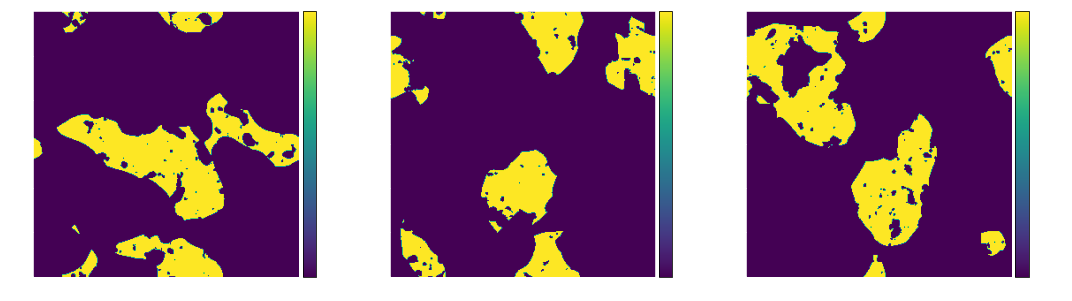

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,15))

img1 = ax1.imshow(ionized[0,:,:], origin='lower')
colorbar(img1)

img2 = ax2.imshow(ionized[:,0,:], origin='lower')
colorbar(img2)

img3 = ax3.imshow(ionized[:,:,0], origin='lower')
colorbar(img3)

plt.tight_layout(h_pad=1)

## Generate Average Neutral Fraction Distributions as a function of blurring methods, shell numbers and σ max

In [24]:
def generate_distributions(
    box = ionized,
    radii = np.arange(8, 17, 1),
    iterations=10**2,
    sigma_factors=[4],
    shell_numbers=[6]
):

    gaussians = []
    spheres = []
    cubes =[]

    for i, radius in enumerate(radii):

        sphere = Average_Neutral_Fraction_Distribution(
                box=box,
                radius=radius,
                iteration=iterations,
                blur_shape='top_hat_sphere'
        )

        cube = Average_Neutral_Fraction_Distribution(
                box=box,
                radius=radius,
                iteration=iterations,
                blur_shape='top_hat_cube'
        )
        
        spheres = np.append(spheres, sphere)
        cubes = np.append(cubes, cube)
        
        
#         #-------------temporary-------------#
        
#         shell_numbers = [int(radius/3), int(2*radius/3)]
#         print(shell_numbers)
        
#         #-------------temporary-------------#

        
        for ii, sigma_factor in enumerate(sigma_factors):
            gaussian = Average_Neutral_Fraction_Distribution(
                box=box,
                radius=radius,
                iteration=iterations,
                sigma_factor=sigma_factor,
                shell_num=shell_numbers[ii],
                blur_shape='Gaussian_sphere'
            )

            gaussians = np.append(gaussians, gaussian)


        # print progress and local time
        current_time = time.strftime('%l:%M:%S%p %Z') # ' 1:36PM EDT '
        print(f'progress = {int(round((i+1)*100/len(radii)))}%, local time = {current_time}')

    gaussians = gaussians.reshape(len(radii), len(sigma_factors), iterations)
    spheres = spheres.reshape(len(radii), iterations)
    cubes = cubes.reshape(len(radii), iterations)
    
    return gaussians, spheres, cubes

## Generate the distributions and storing the data in global variables

In [ ]:
current_time = time.strftime('%l:%M:%S%p %Z')
print(f'Execution cued at {current_time}')

radii = np.arange(48, 3, -4)  # array([34, 32, 30,... 6, 4]) units: voxels
iterations = 10**4
sigma_factors = [4]
shell_numbers = [6]

gaussians, spheres, cubes = generate_distributions(
    radii=radii,
    iterations=iterations,
    sigma_factors=sigma_factors,
    shell_numbers=shell_numbers
)

Execution cued at 10:51:13PM MDT


## Creating Histogram

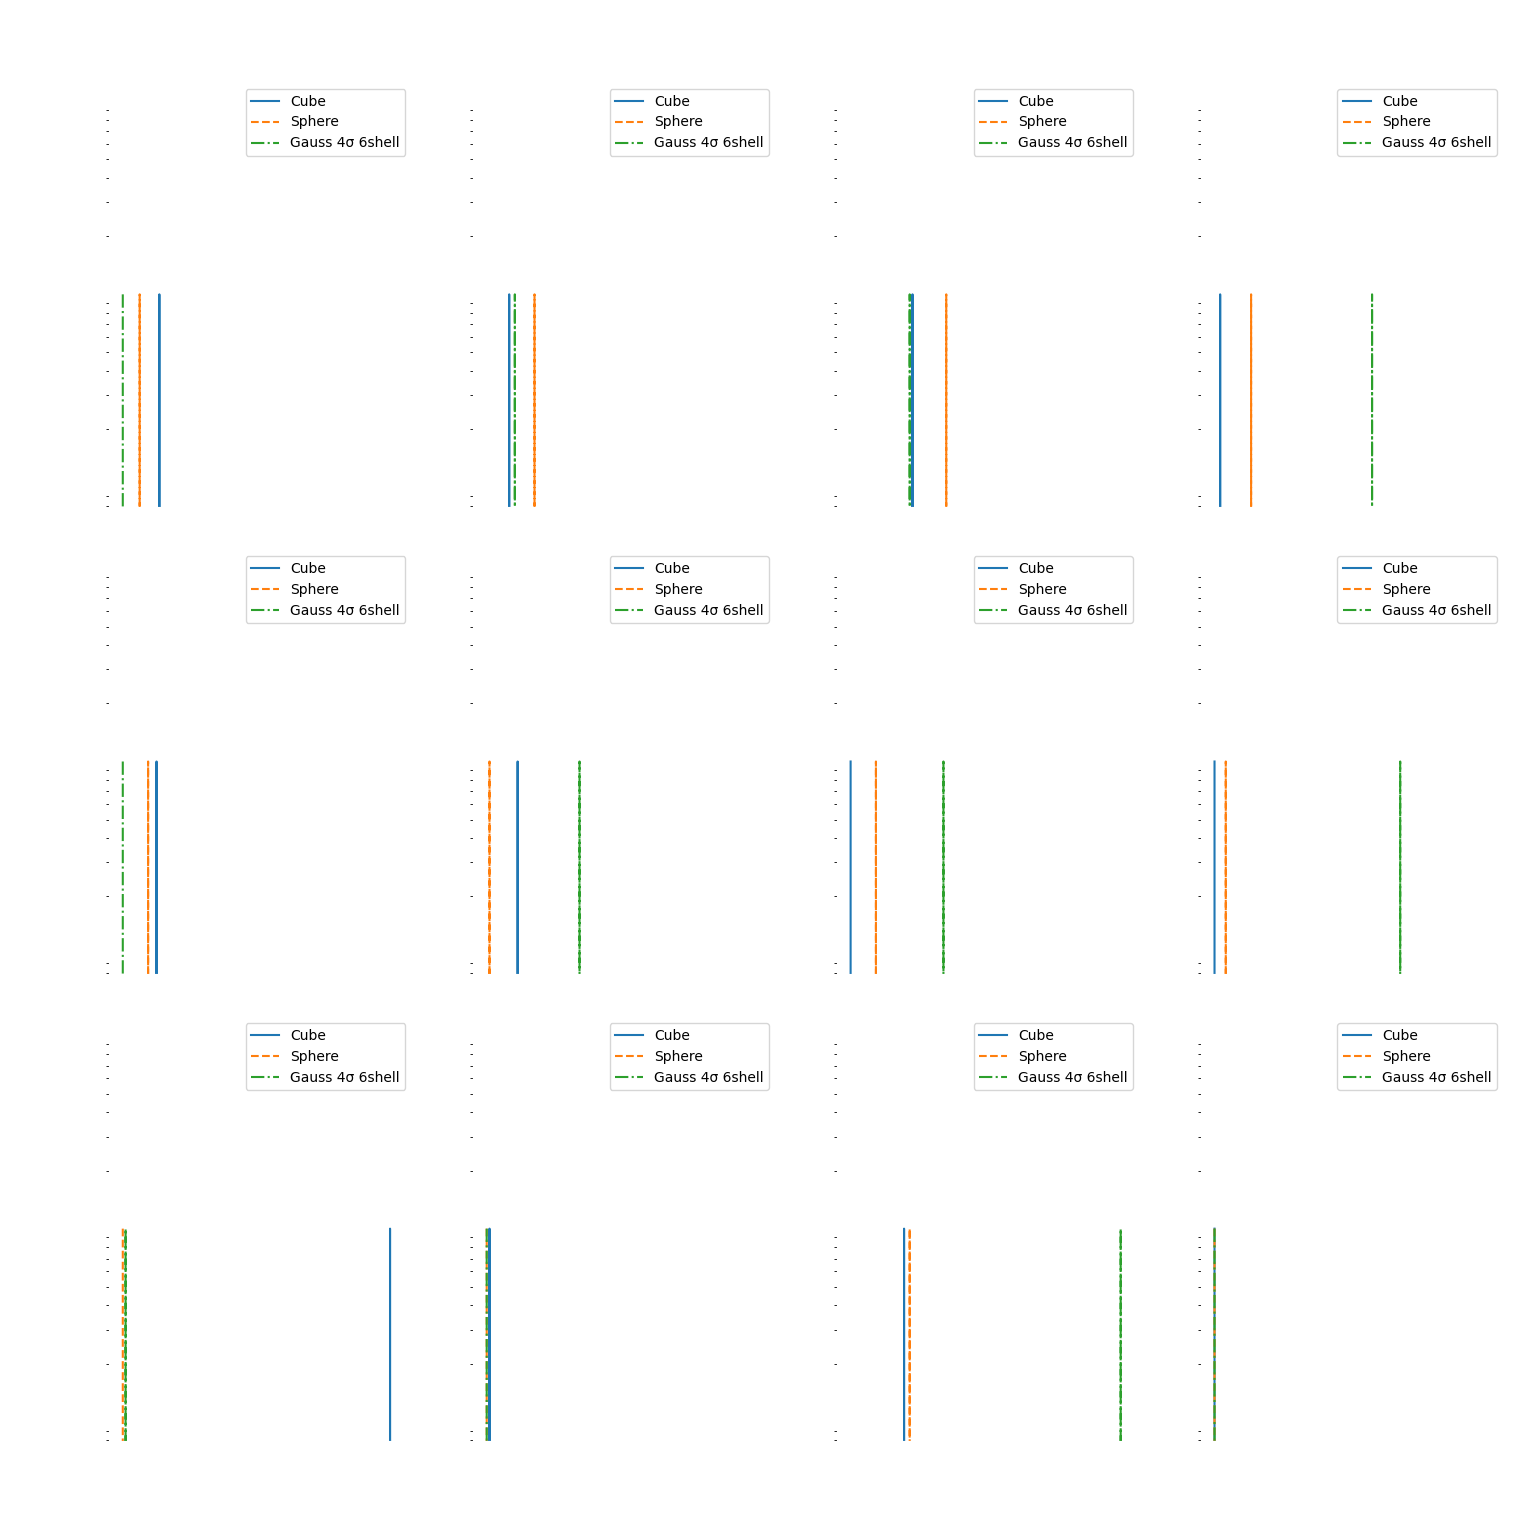

In [39]:
histogram(
    y1s=tuple(cubes), 
    y2s=tuple(spheres), 
    y3s=gaussians, 
    marker_lines=['-.'],
    y1s_label='Cube',
    y2s_label='Sphere',
    y3s_label='Gauss',
    title=[f'Radius={r*BOX_LEN/HII_DIM}Mpc' for r in radii],
    shared_title=f'Distribution of Average \
Neutral Fraction (iterations={iterations:.0e}, redshift={redshift}, {BOX_LEN/301}xBOX_LEN)',
    shared_y_label='Counts',
    shared_x_label='Neutral Fraction',
    figure_shape=(3,4), 
    figure_size=(12,18),
    vertical_gap=0.1,
    horizontal_gap=0.2,
    y_scale='log',
#     y_notation='sci',
    share_y_axis=False
#     dpi=1000
)

## Light cones for Total Average Neutral Fraction vs. redshift plot

lightcone = p21c.run_lightcone(
    redshift = 3,
    max_redshift = 10,
    init_box=init_cond,
    lightcone_quantities=(
        'brightness_temp',
        'xH_box'
    ),
    global_quantities=(
        'brightness_temp',
        'xH_box'
    )
)

## Plotting Total Average Neutral Fraction vs. redshift

fig, ax = p21c.plotting.plot_global_history(lightcone, kind='xH_box')
ax.set_title("Box Total Neutral Fraction vs. Redshift (wider domian)", color='white')
ax.set_ylabel('Box Total Neutral Fraction', color='white')
ax.set_xlabel('Redshift, z', color='white')
ax.tick_params(axis='both', color='white', labelcolor='white')
ax.grid()

for spine in ax.spines.values():  # figure color
    spine.set_edgecolor('white')